In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
import gc
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
_ = files.upload()

Saving NO2+Altitude.zip to NO2+Altitude.zip


In [3]:
!unzip NO2+Altitude.zip -d "NO2+Altitude"
from IPython.display import clear_output
clear_output(wait=False)
!rm NO2+Altitude.zip

In [4]:
files = pd.read_csv("/content/NO2+Altitude/NO2+Altitude/files.csv")

In [5]:
files

,Date,SatFile,GroundFile,AltGrid,Fold
0,2020-05-20,sat_2020-05-20.npy,g_2020-05-20.npy,alt_2020-05-20.npy,1
1,2021-04-27,sat_2021-04-27.npy,g_2021-04-27.npy,alt_2021-04-27.npy,2
2,2020-03-03,sat_2020-03-03.npy,g_2020-03-03.npy,alt_2020-03-03.npy,0
3,2020-10-10,sat_2020-10-10.npy,g_2020-10-10.npy,alt_2020-10-10.npy,2
4,2020-07-17,sat_2020-07-17.npy,g_2020-07-17.npy,alt_2020-07-17.npy,1
...,...,...,...,...,...
481,2020-07-25,sat_2020-07-25.npy,g_2020-07-25.npy,alt_2020-07-25.npy,3
482,2020-08-22,sat_2020-08-22.npy,g_2020-08-22.npy,alt_2020-08-22.npy,2
483,2020-03-23,sat_2020-03-23.npy,g_2020-03-23.npy,alt_2020-03-23.npy,3
484,2020-05-17,sat_2020-05-17.npy,g_2020-05-17.npy,alt_2020-05-17.npy,4


In [6]:
def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true, pred):
    assert true.shape == pred.shape, "true and pred must have the same shape, found {} and {}".format(true.shape, pred.shape)
    scores = []
    for i in range(true.shape[0]):
        scores.append(np.corrcoef(true[i], pred[i])[0, 1])
    return np.mean(scores), scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

In [7]:
def loadData(df,satdir = "/content/NO2+Altitude/NO2+Altitude/satellite/",gdir = "/content/NO2+Altitude/NO2+Altitude/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [8]:
!pip install torch
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.4 MB/s eta 0:00:00


In [46]:
import torch
import torch.nn as nn
from vit_pytorch import ViT

class NestedViT(nn.Module):
    def __init__(self, num_blocks, patch_size, num_classes, dim, depth, heads, mlp_dim, channels, image_size):
        super(NestedViT, self).__init__()
        self.channels = channels
        self.blocks = nn.ModuleList([
            ViT(
                image_size=image_size,
                patch_size=patch_size,
                num_classes=num_classes,
                dim=dim,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                channels=channels
            ) for _ in range(num_blocks)
        ])

    def forward(self, x):
        #print("Input shape:", x.shape)
        dummy = x  # Corrected line
        #print(dummy.shape)
        for i, block in enumerate(self.blocks):
            # Ensure that the dimensions are compatible with ViT input
            #print(f"Before reshape (before block {i + 1}):", dummy.shape)
            batch_size, channels, height, width = dummy.size()
            x = dummy.view(batch_size, channels, height // 48 * 48, width // 64 * 64)   # Dynamic reshape
            #print(f"After reshape (before block {i + 1}):", x.shape)
            x = block(x)
            #print(f"Output shape (after block {i + 1}):", x.shape)
        return x

def build_nested_model(X_train):
    patch_size = 16
    channels = X_train.shape[-1]
    print("Channels:", channels)
    image_height = X_train.shape[1]
    image_width = X_train.shape[2]

    resized_height = patch_size * (image_height // patch_size)
    resized_width = patch_size * (image_width // patch_size)
    print("Resized height:", resized_height)
    print("Resized width:", resized_width)
    assert resized_height > 0 and resized_width > 0, "Image dimensions are too small."

    model = NestedViT(
        num_blocks=4,
        patch_size=patch_size,
        num_classes=3283,
        dim=64,
        depth=16,
        heads=8,
        mlp_dim=128,
        channels=channels,
        image_size=(resized_height, resized_width)
    )

    # Define the loss function
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer


In [47]:
import warnings
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD
from vit_pytorch import ViT
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, ColorJitter
from torchvision import transforms
from torchvision.transforms import Resize
from torch.utils.data import DataLoader
# Model training
scores_list = []
rmses = []
maes = []
patch_size = 16
warnings.filterwarnings("ignore", category=UserWarning)

for fold in range(5):
    print("\nFold {}\n".format(fold))
    train_files = files[files["Fold"] != fold]
    val_files = files[files["Fold"] == fold]

    X_train, Y_train = loadData(train_files)
    X_val, Y_val = loadData(val_files)
    X_train_tensor = torch.from_numpy(X_train)  # Convert X_train to a PyTorch tensor

    desired_height = 48
    desired_width = 64

    # Data augmentation
    transform = transforms.Compose([
        RandomCrop((desired_height, desired_width)),
        RandomHorizontalFlip(),
        ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        Resize((desired_height, desired_width))
    ])

    X_train = transform(torch.Tensor(X_train).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    X_val = transform(torch.Tensor(X_val).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    X_train_tensor = transform(X_train_tensor.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)


    model, criterion, optimizer = build_nested_model(X_train_tensor)
    #print(X_train_tensor.shape)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)  # Example of using SGD optimizer

    if fold == 0:
        #print(model)
        pass

    train_dataset = torch.utils.data.TensorDataset(X_train.permute(0, 3, 1, 2), torch.Tensor(Y_train))
    val_dataset = torch.utils.data.TensorDataset(X_val.permute(0, 3, 1, 2), torch.Tensor(Y_val))

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    patience = 5  # Number of epochs to wait for improvement
    best_val_loss = np.inf
    num_epochs_without_improvement = 0

    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

    for epoch in range(30):
        model.train()
        epoch_train_losses = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()

            resized_inputs = inputs.clone()
            resized_inputs[:, :, :desired_height, :desired_width] = transform(inputs[:, :, :desired_height, :desired_width])

            resized_width = patch_size * (resized_inputs.shape[3] // patch_size)
            resized_inputs = resized_inputs[:, :, :, :resized_width]
            #print(resized_inputs.shape)
            outputs = model(resized_inputs)
            #print("Final output shape:", outputs.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = []
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_outputs.append(outputs)
            val_outputs = torch.cat(val_outputs, dim=0)

        rmse = mean_squared_error(Y_val, val_outputs, squared=False)



        # Update learning rate
        lr_scheduler.step(rmse)

        # Check for early stopping
        if rmse < best_val_loss:
            best_val_loss = rmse
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1
            if num_epochs_without_improvement == patience:
                print("Early stopping criteria met. Stopping training.")
                break

    rmse1 = mean_squared_error(Y_val, val_outputs, squared=False)
    rmses.append(rmse1)
    mae = mean_absolute_error(Y_val, val_outputs)
    maes.append(mae)

    print("Fold {} RMSE Score: {}".format(fold, rmse))
    print("Fold {} MAE Score: {}".format(fold, mae))
    s, ls = pearsonCorrAvgDays(Y_val, val_outputs)
    print("Fold {} Pearson coeff avg over days: {}".format(fold, np.mean([i for i in ls if not pd.isnull(i)])))
    scores_list.append(ls)
    if fold != 4:
        del model
        _ = gc.collect()

print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))


Fold 0

Channels: 1
Resized height: 48
Resized width: 64
Epoch 00011: reducing learning rate of group 0 to 1.0000e-03.
Early stopping criteria met. Stopping training.
Fold 0 RMSE Score: 6.521887454612754
Fold 0 MAE Score: 5.131655812398019
Fold 0 Pearson coeff avg over days: 0.6315845236722932

Fold 1

Channels: 1
Resized height: 48
Resized width: 64
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Early stopping criteria met. Stopping training.
Fold 1 RMSE Score: 7.867896631892841
Fold 1 MAE Score: 5.792902854590037
Fold 1 Pearson coeff avg over days: 0.6466663834441564

Fold 2

Channels: 1
Resized height: 48
Resized width: 64
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Early stopping criteria met. Stopping training.
Fold 2 RMSE Score: 7.424776459420327
Fold 2 MAE Score: 5.634251993362253
Fold 2 Pearson coeff avg over days: 0.6604777798408816

Fold 3

Channels: 1
Resized height: 48
Resized width: 64
Epoch 00006: reducing learning rate of group 0 to 1.00

In [48]:
print(X_train.shape)
print(Y_val.shape)
inp = X_val[0][:,:,0]
print(inp.shape)
#true = Y_val[10].reshape((X_train[0].shape[0],X_train[0].shape[1]))
true = Y_val[0].reshape((49,67))
print(true.shape)
pred = val_outputs[0].reshape((49,67))

torch.Size([270, 48, 64, 1])
(65, 3283)
torch.Size([48, 64])
(49, 67)


Daily true data

In [81]:
import folium
import numpy as np
import branca.colormap as cm
from folium import plugins
# Create a map centered on Ireland
m = folium.Map(location=[53.349805, -6.26031], zoom_start=7)

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1], num_rows + 1)
lon_coords = np.linspace(llcrn[0], urcrn[0], num_cols + 1)
lat, lon = np.meshgrid(lon_coords, lat_coords)


true = np.array(true)

# Initialize a map
# m = folium.Map(location=[53.0, -7.5], zoom_start=7, tiles='Stamen Terrain')

# Convert the numpy array to a GeoJSON-like structure
features = []
for i in range(num_rows):
    for j in range(num_cols):
        polygon = [
            [lat[i, j], lon[i, j]],
            [lat[i + 1, j], lon[i + 1, j]],
            [lat[i + 1, j + 1], lon[i + 1, j + 1]],
            [lat[i, j + 1], lon[i, j + 1]],
            [lat[i, j], lon[i, j]]
        ]
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [polygon]
            },
            'properties': {
                'value': true[i, j]  # Use the corresponding value from the 'true' array
            }
        }
        features.append(feature)

# Define a color scale for the 'true' values
vmin = np.min(true)
vmax = np.max(true)
colormap = cm.linear.YlOrRd_09.scale(vmin, vmax)

# Add the GeoJSON layer to the map and set fill color based on 'true' values
folium.GeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['value']),
        'color': 'none',
        'fillOpacity': 0.6
    }
).add_to(m)


# Add color bar
#colormap.caption = 'Legend'

m.add_child(colormap)

# Define the number of rows and columns in the grid for markers
num_rows_markers = 3
num_cols_markers = 3

# Define the latitude and longitude bounds for the grid for markers
llcrn_markers = [51.7665, -10.3401]
urcrn_markers = [55.422, -6.022]

# Calculate the step size for latitude and longitude for markers
lat_step_markers = (urcrn_markers[0] - llcrn_markers[0]) / num_rows_markers
lon_step_markers = (urcrn_markers[1] - llcrn_markers[1]) / num_cols_markers

# Add markers with both DivIcon and Icon inside the rectangle
for i in range(num_rows_markers + 1):
    for j in range(num_cols_markers + 1):
        lat_marker = llcrn_markers[0] + i * lat_step_markers
        lon_marker = llcrn_markers[1] + j * lon_step_markers

        # DivIcon marker
        div_icon_marker = folium.Marker(
            location=[lat_marker, lon_marker],
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt;">({lat_marker:.4f}, {lon_marker:.4f})</div>')
        )
        div_icon_marker.add_to(m)

        # Icon marker
        icon_marker = folium.Marker(
            location=[lat_marker, lon_marker],
            icon=folium.Icon(color='blue')
        )
        icon_marker.add_to(m)

# Add a rectangle to the map
rectangle_points = [
    [llcrn_markers[0], llcrn_markers[1]],
    [urcrn_markers[0], llcrn_markers[1]],
    [urcrn_markers[0], urcrn_markers[1]],
    [llcrn_markers[0], urcrn_markers[1]],
    [llcrn_markers[0], llcrn_markers[1]],  # Close the rectangle
]

folium.Polygon(
    locations=rectangle_points,
    color='black',  # Line color of the rectangle
    fill=True,
    fill_color='none',  # Fill color of the rectangle
    fill_opacity=0.4,  # Opacity of the fill color
    weight=1.5,  # Width of the rectangle border
).add_to(m)

# Save the map to an HTML file
m.save(f'True_Day_1.html')
m

Daily predicted data

In [82]:
import folium
import numpy as np
import branca.colormap as cm

# Create a map centered on Ireland
m = folium.Map(location=[53.349805, -6.26031], zoom_start=7)

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1], num_rows + 1)
lon_coords = np.linspace(llcrn[0], urcrn[0], num_cols + 1)
lat, lon = np.meshgrid(lon_coords, lat_coords)


pred = np.array(pred).astype(np.float64)

# Initialize a map
# m = folium.Map(location=[53.0, -7.5], zoom_start=7, tiles='Stamen Terrain')

# Convert the numpy array to a GeoJSON-like structure
features = []
for i in range(num_rows):
    for j in range(num_cols):
        polygon = [
            [lat[i, j], lon[i, j]],
            [lat[i + 1, j], lon[i + 1, j]],
            [lat[i + 1, j + 1], lon[i + 1, j + 1]],
            [lat[i, j + 1], lon[i, j + 1]],
            [lat[i, j], lon[i, j]]
        ]
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [polygon]
            },
            'properties': {
                'value': pred[i, j]  # Use the corresponding value from the 'true' array
            }
        }
        features.append(feature)

# Define a color scale for the 'true' values
vmin = np.min(pred)
vmax = np.max(pred)
colormap = cm.linear.YlOrRd_09.scale(vmin, vmax)

# Add the GeoJSON layer to the map and set fill color based on 'true' values
folium.GeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['value']),
        'color': 'none',
        'fillOpacity': 0.6
    }
).add_to(m)

m.add_child(colormap)

# Define the number of rows and columns in the grid for markers
num_rows_markers = 3
num_cols_markers = 3

# Define the latitude and longitude bounds for the grid for markers
llcrn_markers = [51.7665, -10.3401]
urcrn_markers = [55.422, -6.022]

# Calculate the step size for latitude and longitude for markers
lat_step_markers = (urcrn_markers[0] - llcrn_markers[0]) / num_rows_markers
lon_step_markers = (urcrn_markers[1] - llcrn_markers[1]) / num_cols_markers

# Add markers with both DivIcon and Icon inside the rectangle
for i in range(num_rows_markers + 1):
    for j in range(num_cols_markers + 1):
        lat_marker = llcrn_markers[0] + i * lat_step_markers
        lon_marker = llcrn_markers[1] + j * lon_step_markers

        # DivIcon marker
        div_icon_marker = folium.Marker(
            location=[lat_marker, lon_marker],
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt;">({lat_marker:.4f}, {lon_marker:.4f})</div>')
        )
        div_icon_marker.add_to(m)

        # Icon marker
        icon_marker = folium.Marker(
            location=[lat_marker, lon_marker],
            icon=folium.Icon(color='blue')
        )
        icon_marker.add_to(m)

# Add a rectangle to the map
rectangle_points = [
    [llcrn_markers[0], llcrn_markers[1]],
    [urcrn_markers[0], llcrn_markers[1]],
    [urcrn_markers[0], urcrn_markers[1]],
    [llcrn_markers[0], urcrn_markers[1]],
    [llcrn_markers[0], llcrn_markers[1]],  # Close the rectangle
]

folium.Polygon(
    locations=rectangle_points,
    color='black',  # Line color of the rectangle
    fill=True,
    fill_color='none',  # Fill color of the rectangle
    fill_opacity=0.4,  # Opacity of the fill color
    weight=1.5,  # Width of the rectangle border
).add_to(m)

# Save the map to an HTML file
m.save(f'pred_Day_1.html')
m

calculated monthly data

In [84]:
# Initialize variables to store cumulative values
total_inp_month = np.zeros_like(X_val[0][:, :, 0])
total_true_month = np.zeros((49, 67))
total_pred_month = np.zeros((49, 67))

# Loop through the weeks
for month in range(0, 30):
    # Extract data for the current week
    inp_month = X_val[month][:, :, 0]
    true_month = Y_val[month].reshape((49, 67))
    pred_month = val_outputs[month].reshape((49, 67))

    # Accumulate values element-wise
    np.add(total_inp_month, inp_month, out=total_inp_month)
    np.add(total_true_month, true_month, out=total_true_month)
    np.add(total_pred_month, pred_month, out=total_pred_month)

# Calculate average values
avg_inp_month = total_inp_month / 30
avg_true_month = total_true_month / 30
avg_pred_month = total_pred_month / 30


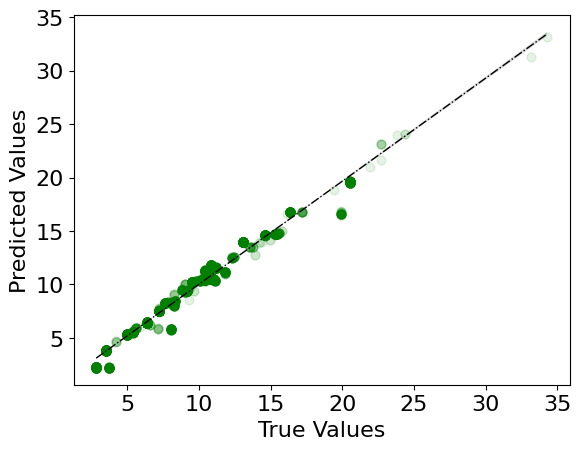

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pred and true are NumPy arrays with the correct shapes
# pred and true are (49, 67) in your case

# Flatten the arrays for plotting
flat_pred = avg_pred_month.flatten()
flat_true = avg_true_month.flatten()

# Create a scatter plot with a regression line and adjusted transparency
sns.regplot(x=flat_true, y=flat_pred, scatter_kws={'s': 40, 'alpha': 0.1,'color': 'green'}, line_kws={'linestyle': '-.', 'color': 'black','linewidth': 1})

# Add labels and title
plt.xlabel('True Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
#plt.title('Regression Plot: True vs. Predicted Values')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.show()

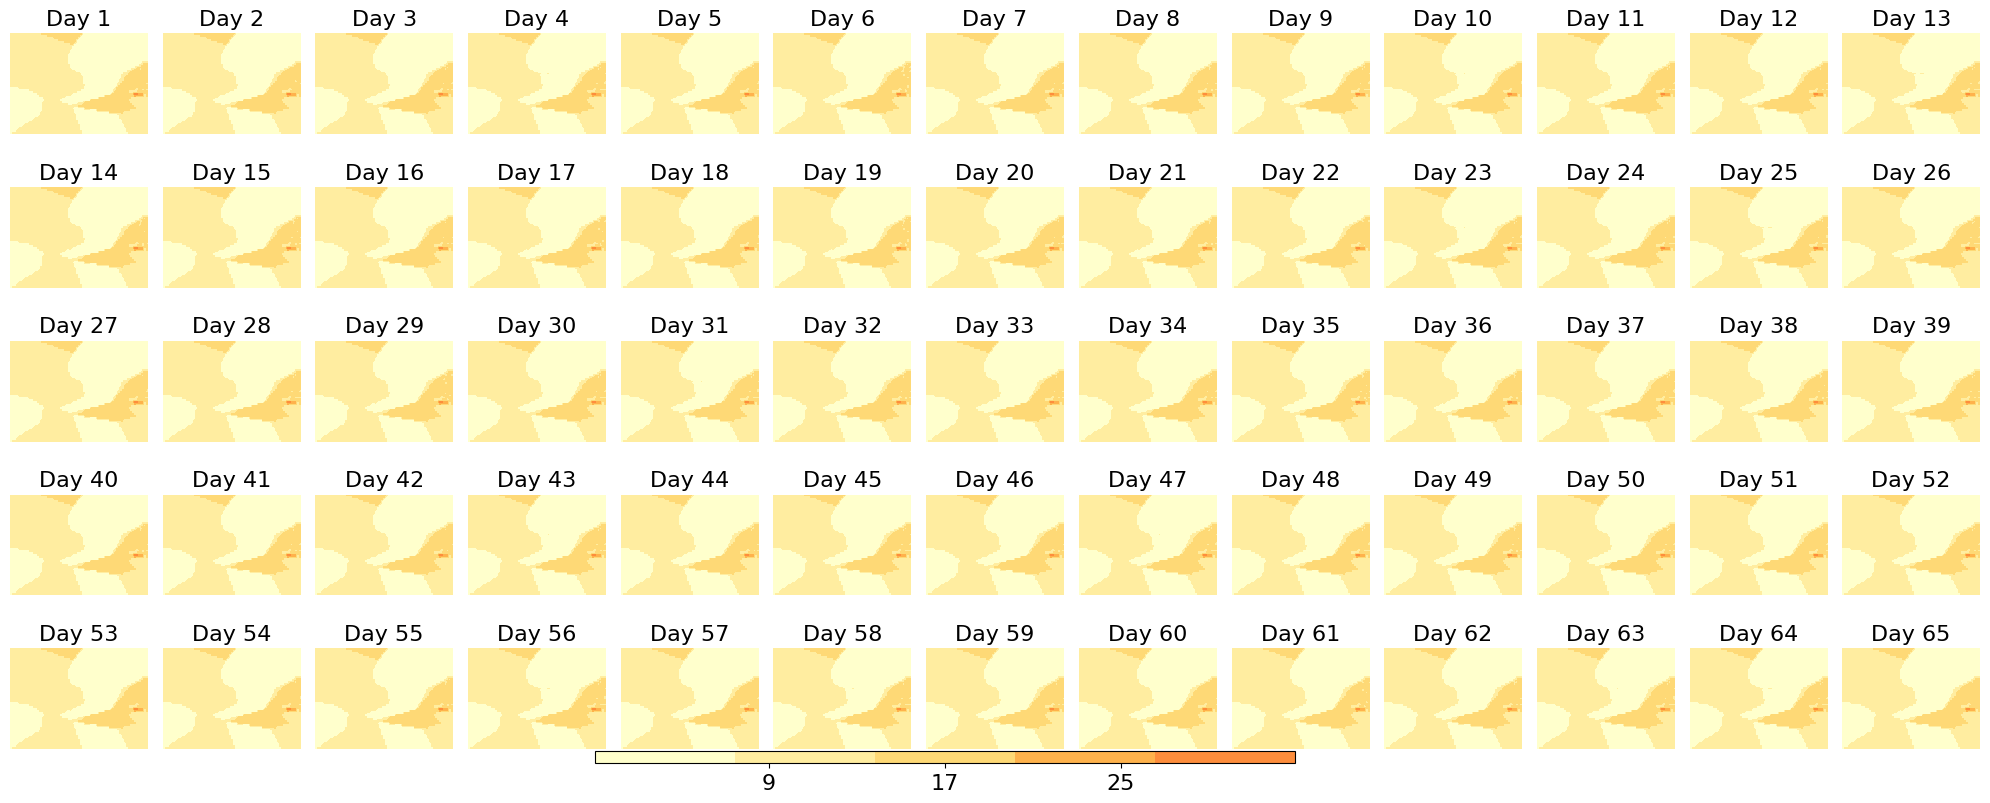

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap



# Define custom colormap
colors = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C']

cmap = ListedColormap(colors)

# Create a subplot for each day
fig, axs = plt.subplots(5, 13, figsize=(20, 8))

# Flatten the subplot array for easier iteration
axs = axs.flatten()

# Loop through each day and create a heatmap
for i in range(65):
    ax = axs[i]
    prediction = val_outputs[i].reshape((49, 67))
    im = ax.imshow(prediction, cmap=cmap)  # Use the custom colormap
    ax.set_title(f'Day {i + 1}',fontsize=16)
    ax.axis('off')

# Convert val_outputs to a flattened array
#val_outputs_flat = val_outputs.flatten()
val_outputs_flat = np.array(val_outputs).astype(np.float64)
# Calculate colorbar ticks based on the actual minimum and maximum values in the dataset
min_value = np.min(val_outputs_flat)
max_value = np.max(val_outputs_flat)
num_ticks = 5  # Show five ticks on the colorbar

# Add minimum and maximum values to the colorbar ticks
tick_positions = np.linspace(min_value, max_value, num_ticks)
tick_positions = np.insert(tick_positions, 0, min_value)  # Add min_value to the beginning
tick_positions = np.append(tick_positions, max_value)  # Add max_value to the end
tick_labels = [f'{int(value)}' for value in tick_positions]

# Add a colorbar for reference
cbar_ax = fig.add_axes([0.3, 0.03, 0.35, 0.015])  # Adjust these values as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=tick_positions)
cbar.ax.tick_params(labelsize=16)
cbar.set_ticklabels(tick_labels)
#cbar.set_label('Concentration')  # Change this label based on your data

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
